# 顔認識　サンプルソース

---
**「顔認識の基礎知識」で解説したOSSライブラリを使用して、**  
**入力した写真から特定の人物の顔を認識させるプログラムです。** 

---
### **■処理に必要なライブラリをインポートします【参考：第三章】**

In [1]:
# ライブラリのインポート
import face_recognition # Face recognition:顔認識
import dlib             # Dlib:機械学習
import cv2              # OpenCV:画像処理
from matplotlib import pyplot as plt # 画像表示
import time             # 処理時間計測


### **■各種パラメータを設定します【参考：第六章、第七章】**

①検出モデル  
hog:計算量は少ないですが、精度は低いです。  
cnn:計算量は多いですが、精度は高いです。  

②顔検出精度  
数字を大きくすると精度が上がりますが、計算量も上がります。デフォルトは1です。  
2より大きくするとマシン負荷が高くなりすぎる可能性があります。  

③顔認識の閾値  
値を低くするほど判定が厳しくなり、高くするほど判定が緩くなります。デフォルトは0.6です。  
複数の顔がある写真の認識で、ほとんどの顔が同一となった場合、  
この数値を調整することで、より精度の高い認識を行うことができます。  


In [2]:
# ------- パラメータ --------------------------------
# 検出モデル
MODEL = "hog"
#MODEL = "cnn"

# 顔検出精度
UPSAMPLE = 1

# 顔認識の閾値
TOLERANCE = 0.6
# ---------------------------------------------------

### **■OpenCVを使って画像(顔写真)を入力します【参考：第四章】**

顔認識対象の画像と顔認識させる画像の2枚を読み込みます。  

OpenCV はカラーフォーマットが BGR 形式であるため、  
一般的な RGB 形式にするためには、読み込み後に変換が必要です。

In [3]:
# 画像ファイル読み込み
image         = cv2.imread(r"Photo/family_1_papa.jpg")
unknown_image = cv2.imread(r"Photo/family_2.jpg")

# BGR→RGBに変換
image         = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
unknown_image = cv2.cvtColor(unknown_image, cv2.COLOR_BGR2RGB)

### **■face_recognitionを使って写真から顔を検索します【参考：第五章、第六章】**

画像に写っているすべての顔を検索します。  
指定した検出モデルとアップサンプリング回数で処理を行います。

検出モデルをcnnにしたり、アップサンプリング回数を増やすと、処理に時間が掛かります。  
完了後に処理時間が表示されます。

顔を検出できなかった場合はここで終了です。

In [4]:
# 時間計測 ： 開始時刻を記録
cp_0 = time.time() 

# 画像に写っているすべての顔を検索
face_locations = face_recognition.face_locations(unknown_image, model=MODEL, number_of_times_to_upsample=UPSAMPLE)

# 時間計測 ： 終了時刻を記録
cp_1 = time.time() 
time_hog = cp_1 - cp_0 # [終了時刻 - 開始時刻] から処理時間を算出 
print ("face_locations time :{0}".format(time_hog) + "[sec]", flush=True)

# 顔を検出できなかった場合、ここで終了
if len(face_locations) <= 0:
    raise SystemExit("Face Not Found")

face_locations time :0.5967249870300293[sec]


### **■face_recognitionを使って顔認識を行います【参考：第七章】**

検出した顔のデータを、認識させる顔データと比較して、認識結果と認識値を出力します。  
検出した顔が複数ある場合、すべての顔データと比較します。

認識結果は True/False のいずれかで出力します。  
認識値は 0 に近いほど顔が似ていると判断したことになります。

In [5]:
# 顔を検出できた場合、顔認識を行う
print("I found {} face(s) in this photograph.".format(len(face_locations)))

# 比較元の顔のエリアを指定する
known_face_encodings = face_recognition.face_encodings(image)[0]

# 検出した各顔の顔認識を行うループ
resultslist = []
distslist = []
for index in range(len(face_locations)):

    # 比較先の顔のエリアを指定する
    unknown_encoding = face_recognition.face_encodings(unknown_image, face_locations)[index]

    # 認識結果を出力
    results = face_recognition.compare_faces([known_face_encodings], unknown_encoding, TOLERANCE)
    print(results)
    resultslist.append(results)

    # 認識値を出力
    dists = face_recognition.face_distance([known_face_encodings], unknown_encoding)
    print(dists)
    distslist.append(dists)


I found 4 face(s) in this photograph.
[False]
[0.70802824]
[False]
[0.80408018]
[True]
[0.39837144]
[False]
[0.82534138]


### **■OpenCVを使って顔認識の結果を出力します【参考：第八章】**

画像から検出した顔を枠で囲み、認識結果と認識値を描画します。

描画後は別ウィンドウで画像を表示し、さらにファイルとして保存します。

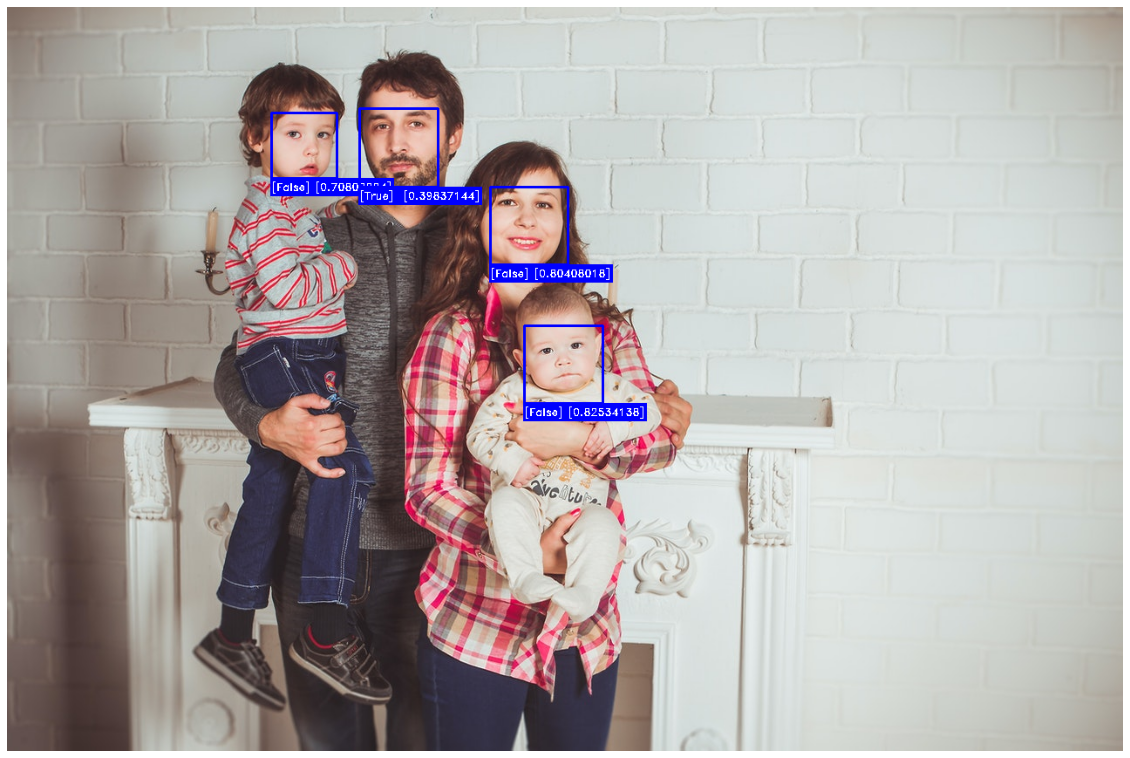

In [6]:
# 認識した結果を画像に合成するループ
rect_color = (0, 0, 255)     # 青枠
font = cv2.FONT_HERSHEY_DUPLEX
fontsize = 0.4
font_color = (255, 255, 255) # 白文字
index = 0
for top, left, bottom, right in face_locations:
    # 顔を枠で囲む
    cv2.rectangle(unknown_image, (left, top), (right, bottom), rect_color, thickness=2)

    # 認識結果と値を描き込む
    cv2.rectangle(unknown_image, (right - 1, bottom), (right + 140, bottom + 20), rect_color, thickness=-1)
    cv2.putText(unknown_image, str(resultslist[index]), (right, bottom + 14), font, fontsize, font_color, 1)
    cv2.putText(unknown_image, str(distslist[index]), (right + 50, bottom + 14), font, fontsize, font_color, 1)
    index += 1

# 画像を出力【matplotlib】
fig, ax = plt.subplots(figsize=(20, 20))
ax.imshow(unknown_image)
ax.set_axis_off()
fig.savefig("Photo/output.jpg")

# 画像を出力【OpenCV】
#output_image = cv2.cvtColor(unknown_image, cv2.COLOR_RGB2BGR)
#cv2.imwrite("Photo\output.jpg", output_image) # 保存
#cv2.imshow("image",output_image)
#cv2.waitKey(0)
#cv2.destroyAllWindows()